# Investigating model range versus observations

0320: Richard's request  
Small script to see whether the range that we are seeing in these ensembles is reasonable compared to the interannual range in observations ts.  
Approach will be to aggregate observations to annual, take the std of this time series; do the same for all models in an ensemble.  
Plot as a boxplot (use pandas to make this easier)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date
import os
from collections import defaultdict
import itertools
import xarray as xr
import cftime

# my functions
from GradTrendClasses import ModelInput, CalculateObsGradient, Gradient
from GradientProjectFunctions import RemoveClimatology, ClassifyHistModelsLite, CreateScenarioDictionary, ConcatModels, ExtendPeriod

### Setting up directories

In [2]:
# Inputs
#_____Hadley___________
HadDir = '/home/hbyrne/Research/QMDA_2023'

#_____Inputs__________
obsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Inputs'

#_____openDap_________
openDapDir = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

#_____gradients______
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_MASTER'

In [3]:
# Outputs
#_____Plots________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
plotsEnd = 'RangeBoxPlots' + str(date.today())

plotsDir = pathBase + plotsEnd

## Observations

In [5]:
fileName = 'HadISST_sst 2.nc'
os.chdir(HadDir)

# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# aggregating to annual values
modelInput = modelInput.groupby('time.year').mean(dim = 'time')

# calculating the gradient
gradientHad = CalculateObsGradient(modelInput, 'HadleyISST')

# Noting start and end time for all input datasets so that we can make sure we're comparing to the same periods
yearStartObs = []
yearEndObs = []

yearStartObs.append(min(gradientHad.gradient.year).item())
yearEndObs.append(max(gradientHad.gradient.year).item())

In [6]:
# trying input for COBE
fileName = 'COBE.nc'

os.chdir(obsDir)

# running the classes on it
modelInput = ModelInput(fileName)

# remove climatology
modelInput = RemoveClimatology(modelInput.ds)

# aggregating to annual values
modelInput = modelInput.groupby('time.year').mean(dim = 'time')

# calculating the gradient
gradientCOBE = CalculateObsGradient(modelInput, 'COBE')

# Noting start and end time for all input datasets so that we can make sure we're comparing to the same periods
yearStartObs.append(min(gradientCOBE.gradient.year).item())
yearEndObs.append(max(gradientCOBE.gradient.year).item())

## Models

In [9]:
yearStartAll = max(yearStartObs)
yearEndAll = min(yearEndObs)

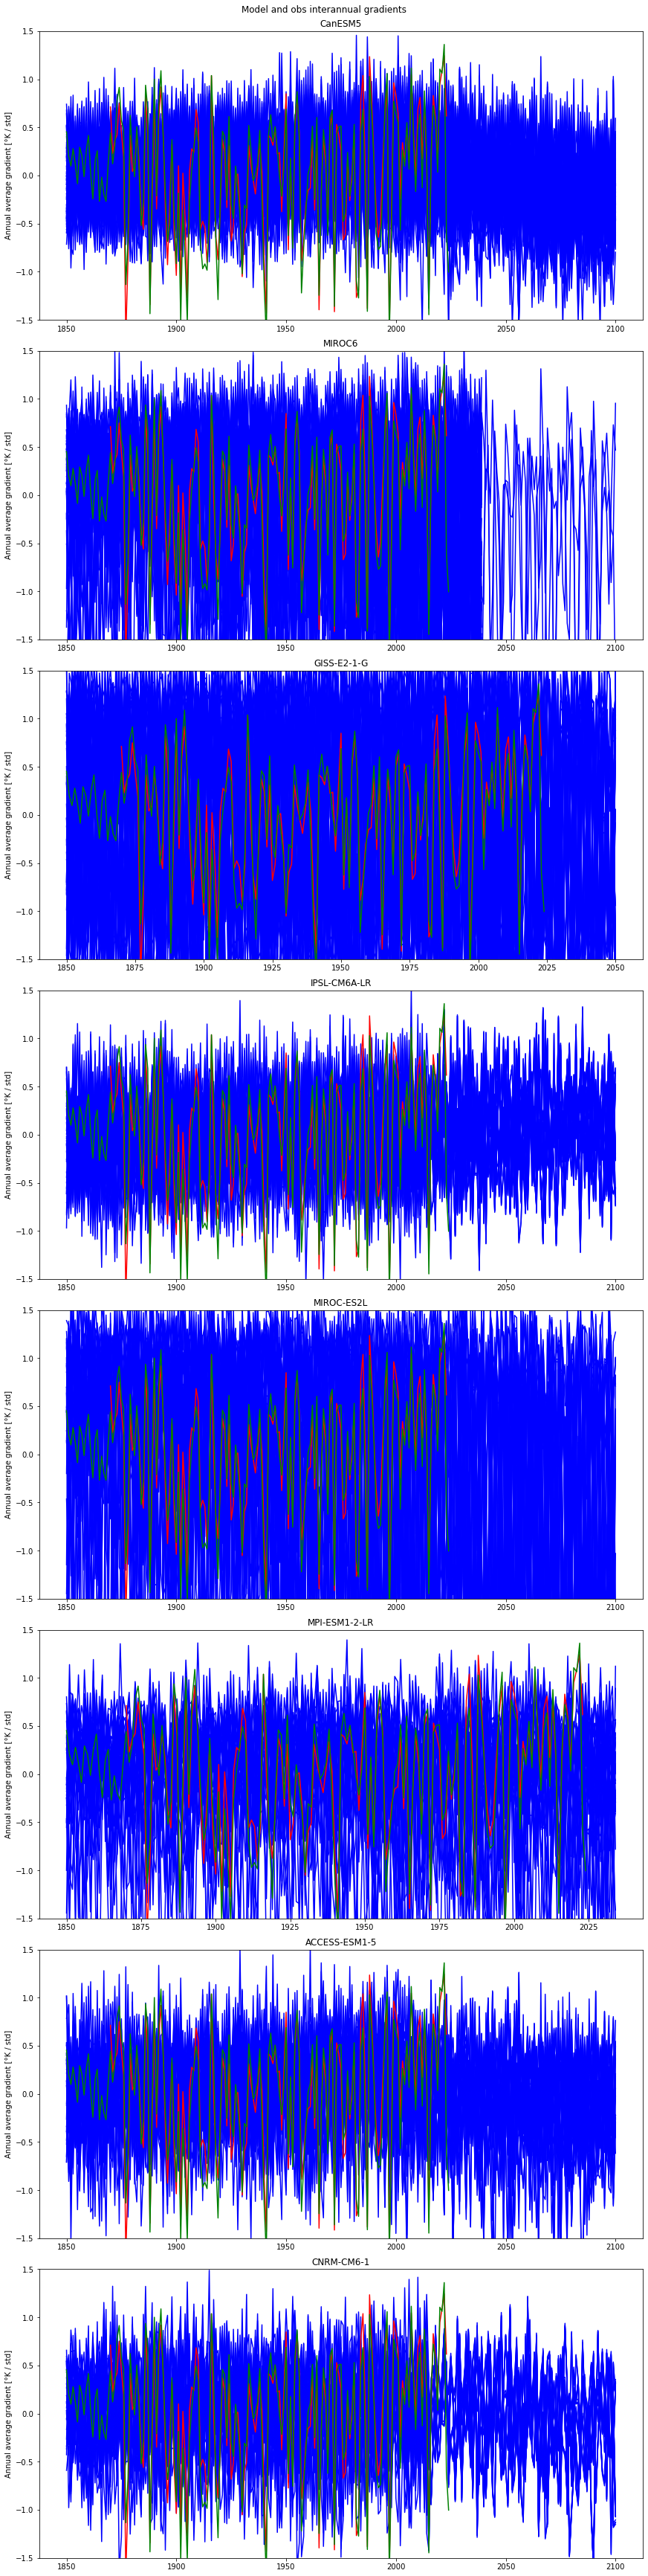

In [13]:
# defining the dates for the overlapping periods of the observations | max of the start year and min of the end year
yearStartAll = max(yearStartObs)
yearEndAll = min(yearEndObs)

# calculating std for the specific periods for the obs
stdObsGradientHad = gradientHad.gradient.sel(year = slice(yearStartAll, yearEndAll)).std().item()
stdObsGradientCOBE = gradientCOBE.gradient.sel(year = slice(yearStartAll, yearEndAll)).std().item()

# pulling in the gradient files instead
os.chdir(gradientsDir)

# models = ['CanESM5', 'MIROC6', 'GISS-E2-1-G', 'IPSL-CM6A-LR']
# models = ['MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1']
# NOTE THAT SOMETHING IS WRONG WITH MPI SO EXCLUDING FOR NOW
models = ['CanESM5', 'MIROC6', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'CNRM-CM6-1']

# creating a dictionary to hold the standard deviations
dictStdModels = defaultdict(list)

# also plotting to see if the std makes sense
nFigures = len(models)
nRows = nFigures

if nFigures % nRows == 0:
    nCols = int(nFigures/nRows)
else:
    nCols = int(np.floor(nFigures/nRows) + 1)

subplotSize = (12, 6)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


fig, axes = plt.subplots(nrows = nRows, ncols = nCols, figsize = (figWidth,figHeight), constrained_layout = True)
fig.suptitle('Model and obs interannual gradients')

for i, modelName in enumerate(models):
    # get a list of all of the files in the directory (getting rid of the python checkpoints one)
    gradientFiles = os.listdir(gradientsDir)
    gradientFiles = [f for f in gradientFiles if '.nc' in f and modelName in f]

    for file in gradientFiles:
        # opening the file
        gradientData = xr.open_dataset(file)

        # calculating the std
        gradAnnual = gradientData.ts.groupby('time.year').mean(dim = 'time')
        std = gradAnnual.sel(year = slice(yearStartAll, yearEndAll)).std().item()
        dictStdModels[modelName].append(std)
        
        axes[i].plot(gradAnnual.year, gradAnnual, color = 'blue')
    
    axes[i].plot(gradientHad.gradient.year, gradientHad.gradient, color = 'red')
    axes[i].plot(gradientCOBE.gradient.year, gradientCOBE.gradient, color = 'green')
    axes[i].set_ylim([-1.5, 1.5])
    axes[i].set_title(f'{modelName}')
    axes[i].set_ylabel('Annual average gradient [°K / std]')

# saving this figure

if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'GradientRangeModelObs_Batch2.png'
plt.savefig(fileName)
    
# create a list of the lists
listStdModels = []


for key, value in dictStdModels.items():
    listStdModels.append(value)

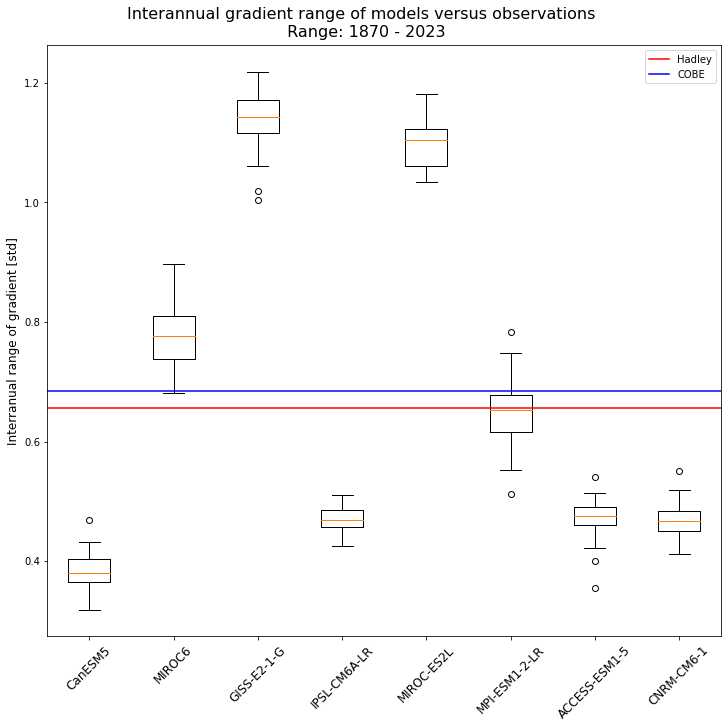

In [14]:
# plotting

fig, ax = plt.subplots(figsize = (10,10), constrained_layout = True)
fig.suptitle(f'Interannual gradient range of models versus observations \n Range: {yearStartAll} - {yearEndAll}', fontsize = 16)
ax.boxplot(listStdModels)
ax.set_ylabel('Interranual range of gradient [std]', fontsize = 12)
ax.axhline(y = stdObsGradientHad, color = 'red', label = 'Hadley')
ax.axhline(y = stdObsGradientCOBE, color = 'blue', label = 'COBE')
ax.set_xticklabels(models, fontsize = 12, rotation = 45)
ax.legend()

if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'BoxPlotsGradientRange_Batch2.png'
plt.savefig(fileName)

plt.show()

In [25]:
stdObsGradientCOBE

0.6846580505371094

In [21]:
medians

[0.38040261604698694,
 0.7759037331205949,
 1.1429682991120487,
 0.46790188550949097,
 1.104776434976691,
 0.6527827481666814,
 0.47563844058774796,
 0.4672016898241459]